In [1007]:
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import spline

In [1008]:
%matplotlib inline
pd.set_option('display.max_columns', 500)

## Reading in the CSV

In [1009]:
df = pd.read_csv(
    'ny_phil.csv', 
    dtype={'interval': object},
    error_bad_lines=False)
df['Date'] = pd.to_datetime(df['Date'])

In [1010]:
df.shape

(806179, 17)

In [1011]:
df

,Date,Location,Time,Venue,eventType,id,composerName,conductorName,interval,movement,workTitle,soloistInstrument,soloistName,soloistRoles,season,programID,orchestra
0,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,"Beethoven, Ludwig van","Hill, Ureli Corelli",NaN,NaN,"SYMPHONY NO. 5 IN C MINOR, OP.67",Soprano,"Otto, Antoinette",S,1842-43,3853.0,New York Philharmonic
1,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,"Beethoven, Ludwig van","Hill, Ureli Corelli",NaN,NaN,"SYMPHONY NO. 5 IN C MINOR, OP.67",Piano,"Scharfenberg, William",A,1842-43,3853.0,New York Philharmonic
2,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,"Beethoven, Ludwig van","Hill, Ureli Corelli",NaN,NaN,"SYMPHONY NO. 5 IN C MINOR, OP.67",Violin,"Hill, Ureli Corelli",A,1842-43,3853.0,New York Philharmonic
3,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,"Beethoven, Ludwig van","Hill, Ureli Corelli",NaN,NaN,"SYMPHONY NO. 5 IN C MINOR, OP.67",Viola,"Derwort, G. H.",A,1842-43,3853.0,New York Philharmonic
4,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,"Beethoven, Ludwig van","Hill, Ureli Corelli",NaN,NaN,"SYMPHONY NO. 5 IN C MINOR, OP.67",Cello,"Boucher, Alfred",A,1842-43,3853.0,New York Philharmonic
5,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,"Beethoven, Ludwig van","Hill, Ureli Corelli",NaN,NaN,"SYMPHONY NO. 5 IN C MINOR, OP.67",Contrabass,"Rosier, F. W.",A,1842-43,3853.0,New York Philharmonic
6,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,"Beethoven, Ludwig van","Hill, Ureli Corelli",NaN,NaN,"SYMPHONY NO. 5 IN C MINOR, OP.67",Soprano,"Otto, Antoinette",S,1842-43,3853.0,New York Philharmonic
7,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,"Beethoven, Ludwig van","Hill, Ureli Corelli",NaN,NaN,"SYMPHONY NO. 5 IN C MINOR, OP.67",Tenor,"Horn, Charles Edward",S,1842-43,3853.0,New York Philharmonic
8,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,"Beethoven, Ludwig van","Hill, Ureli Corelli",NaN,NaN,"SYMPHONY NO. 5 IN C MINOR, OP.67",Tenor,"Horn, Charles Edward",S,1842-43,3853.0,New York Philharmonic
9,1842-12-07 05:00:00,"Manhattan, NY",8:00PM,Apollo Rooms,Subscription Season,38e072a7-8fc9-4f9a-8eac-3957905c0002,"Beethoven, Ludwig van","Hill, Ureli Corelli",NaN,NaN,"SYMPHONY NO. 5 IN C MINOR, OP.67",Soprano,"Otto, Antoinette",S,1842-43,3853.0,New York Philharmonic


## Get some information

In [1012]:
len(df['composerName'].unique())

2767

In [1013]:
len(df['Location'].unique())

490

In [1014]:
df['Venue'].value_counts().head(10)

Avery Fisher Hall                  235073
Lewisohn Stadium                   153053
Carnegie Hall                      107572
Riverside Church                    71244
Philharmonic Hall                   52060
Merkin Concert Hall                 30970
The Stanley H. Kaplan Penthouse      8721
PNC Bank Performing Arts Center      8492
David Geffen Hall                    8202
Aeolian Hall                         6322
Name: Venue, dtype: int64

In [1015]:
df['eventType'].value_counts().head(10)

Subscription Season            289783
Stadium Concert                153805
Holiday Brass                   74448
Chamber                         44350
Promenade                       33276
Young People's Concert          28548
Tour                            24686
Special                         23364
Parks                           23242
Very Young People's Concert     13590
Name: eventType, dtype: int64

In [1016]:
df['orchestra'].value_counts().head(10)

New York Philharmonic                       386512
Stadium-NY Philharmonic                     146647
Musicians from the New York Philharmonic    145504
New York Symphony                            41094
Members of NY Philharmonic                   20972
NYP Presentation                             20187
NY Philharmonic Ensembles                    19338
New/National Symphony Orchestra                753
Members of NY Symphony                         158
Strike Orchestra (Philharmonic)                 41
Name: orchestra, dtype: int64

## Instruments

In [1017]:
df['soloistInstrument'].value_counts().head()

Dancer     77108
Soprano    72563
Piano      72188
Violin     52903
Trumpet    46454
Name: soloistInstrument, dtype: int64

In [1018]:
df['soloistInstrument'].value_counts().tail()

Production Supervisor    3
Vocals, Percussion       3
Theatre Company          1
Stage Manager            1
Video Operator           1
Name: soloistInstrument, dtype: int64

In [1040]:
df.groupby('soloistInstrument').filter(lambda x: (len(x)<500) & (len(x) > 100))['soloistInstrument'].unique()

array(['Bass Clarinet', 'Vocal Group', 'Unspecified Voice',
       'Vocal Quartet', 'String Quartet', 'Solo Voice', 'Drum',
       'Xylophone', 'Folk Singer', 'Contrabassoon', "Oboe d'Amore",
       'Theremin', 'Viola da Gamba', 'Basset Horn', 'Accordion',
       'Drummers and Dancers', 'Folk Group', 'Saxophone', 'Harmonica',
       'Mime', 'Boy Soprano', 'Mandolin', 'Male Voice', 'Balladeer',
       'Marionettes', 'Recorder', 'Cimbalom', 'Jazz Quartet', 'Jazz Piano',
       'Alto Saxophone', 'Ensemble, Featured', 'Tenor Saxophone',
       'Tarabuka', 'Oud', 'Electric Guitar', 'Celeste', 'Euphonium',
       'Clapping and Vocals', 'Keyboard', 'Sheng', 'Author',
       'Production Design', 'Trombone/Baritone', 'Storywriter'], dtype=object)

In [883]:
df_intruments = df.groupby(df.Date.dt.year)['soloistInstrument'].value_counts(normalize=True).reset_index(name='count')

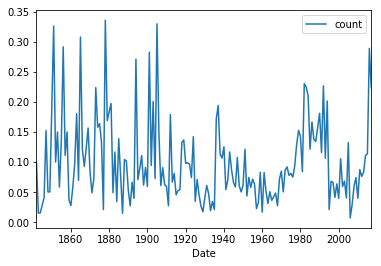

In [884]:
df_intruments[df_intruments['soloistInstrument'] == 'Violin'].plot(x='Date', y='count')

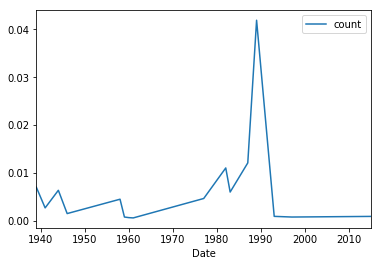

In [885]:
df_intruments[df_intruments['soloistInstrument'] == 'Saxophone'].plot(x='Date', y='count')

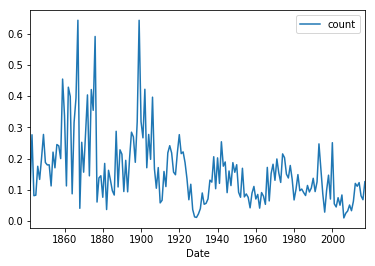

In [886]:
df_intruments[df_intruments['soloistInstrument'] == 'Piano'].plot(x='Date', y='count')

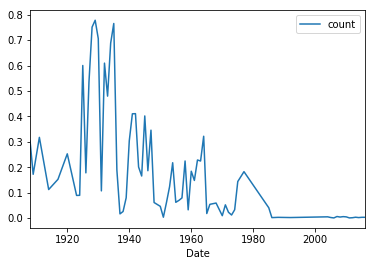

In [889]:
df_intruments[df_intruments['soloistInstrument'] == 'Dancer'].plot(x='Date', y='count')

In [903]:
# Isolate the instruments
df_intruments = df[['soloistInstrument', 'Date']]
#df_intruments.drop_duplicates(inplace=True)

In [904]:
# The 10 most popular solo instruments
popular_instruments_list = df_intruments['soloistInstrument'].value_counts().nlargest(10).index.tolist()
popular_instruments = df_intruments[df_intruments.soloistInstrument.isin(popular_instruments_list)]
popular_instruments_list

['Dancer',
 'Soprano',
 'Piano',
 'Violin',
 'Trumpet',
 'Chorus',
 'Tenor',
 'Cello',
 'Baritone',
 'French Horn']

In [905]:
# Plot the 10 most popular instruments over time
popular_instruments_plot = (popular_instruments
 .groupby(popular_instruments.Date.dt.year)
 ['soloistInstrument'].value_counts(normalize=True).reset_index(name='count'))

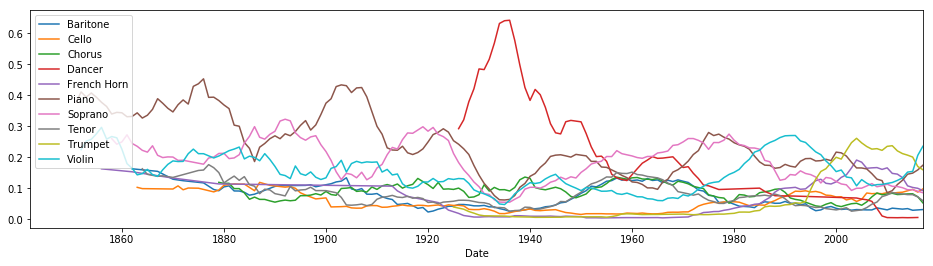

In [906]:
fig, ax = plt.subplots(figsize=(16,4))

for label, dfi in popular_instruments_plot.groupby('soloistInstrument'):
    dfi.rolling(10, on='Date').mean().plot(x='Date', y='count', ax=ax, label=label)
    
plt.show()

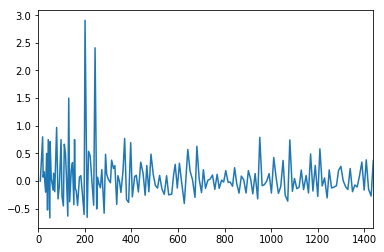

In [867]:
(popular_instruments_plot[popular_instruments_plot['soloistInstrument'] == 'Piano']
 .sort_values(by='Date')
 ['count'].pct_change(periods=1).plot())

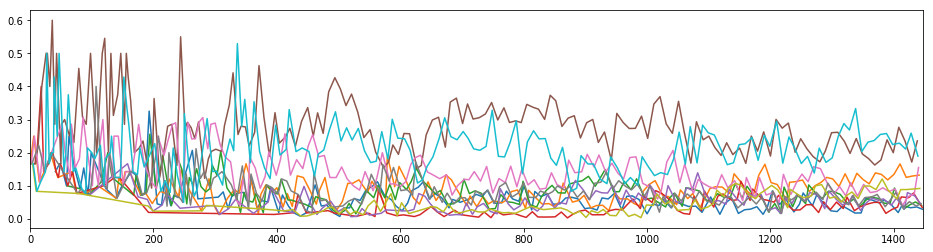

In [890]:
fig, ax = plt.subplots(figsize=(16,4))

for label, dfi in popular_instruments_plot.groupby('soloistInstrument'):
    dfi['count'].plot(x='Date', y='count', ax=ax, label=label)
    
plt.show()

## Number of concerts

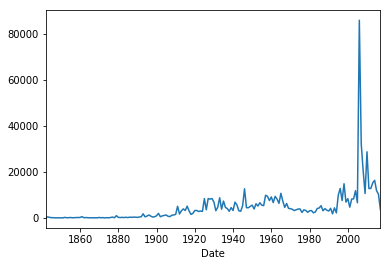

In [826]:
df.groupby(df.Date.dt.year)['id'].count().plot(x='Date', y='id')

In [827]:
df_date = df
df_date.index = df['Date']

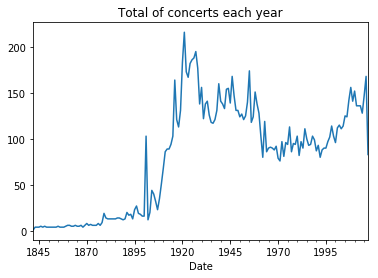

In [898]:
df_date.resample('A')['id'].nunique().plot(title='Total of concerts each year')

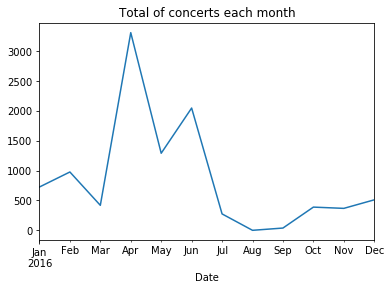

In [829]:
(df_date[df_date.index.year == 2016]
 .resample('M')
 ['id'].count()
 .plot(title='Total of concerts each month'))

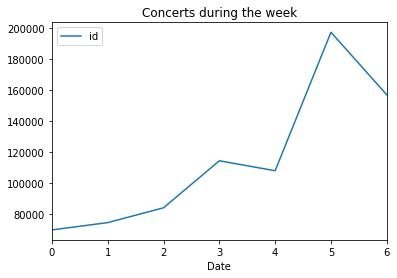

In [830]:
df_date.groupby(df.index.dayofweek).count().plot(y='id', title='Concerts during the week')

## Composers

In [831]:
# Isolate the composers and get rid of the duplicates
df_composers = df[['composerName', 'Date']]
df_composers.drop_duplicates(inplace=True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [912]:
# Most played composer by year
(df_composers.groupby(df_composers.index.year)
 ['composerName'].value_counts()
 .groupby(level=0)
 .nlargest(1)
 .tail(12))

Date  Date  composerName               
2006  2006  Mozart,  Wolfgang  Amadeus     50
2007  2007  Beethoven,  Ludwig  van        39
2008  2008  Beethoven,  Ludwig  van        41
2009  2009  Brahms,  Johannes              35
2010  2010  Mozart,  Wolfgang  Amadeus     41
2011  2011  Beethoven,  Ludwig  van        45
2012  2012  Tchaikovsky,  Pyotr  Ilyich    41
2013  2013  Mozart,  Wolfgang  Amadeus     35
2014  2014  Beethoven,  Ludwig  van        34
2015  2015  Tchaikovsky,  Pyotr  Ilyich    31
2016  2016  Beethoven,  Ludwig  van        36
2017  2017  Beethoven,  Ludwig  van        24
Name: composerName, dtype: int64

In [833]:
df_composers['composerName'].value_counts().head(10)

Beethoven,  Ludwig  van        4751
Tchaikovsky,  Pyotr  Ilyich    3242
Mozart,  Wolfgang  Amadeus     3216
Brahms,  Johannes              2941
Wagner,  Richard               2781
Strauss,  Richard              1901
Mendelssohn,  Felix            1524
Bach,  Johann  Sebastian       1514
Dvorak,  Antonín               1491
Ravel,  Maurice                1438
Name: composerName, dtype: int64

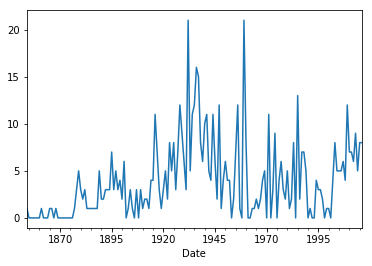

In [834]:
(df_composers[df_composers['composerName'] == 'Handel,  George  Frideric']
 ['composerName'].resample('A')
 .count()
 .plot())

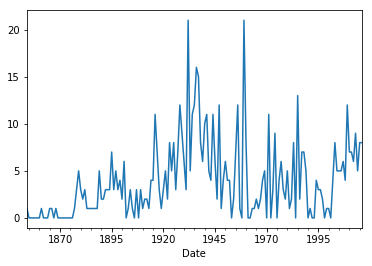

In [835]:
# Handel over the years
(df_composers[df_composers['composerName'] == 'Handel,  George  Frideric']
 ['composerName'].resample('A')
 .count()
 .plot())

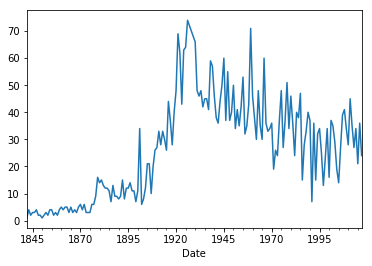

In [836]:
# Beethoven over the years
(df_composers[df_composers['composerName'] == 'Beethoven,  Ludwig  van']
 ['composerName'].resample('A')
 .count()
 .plot())

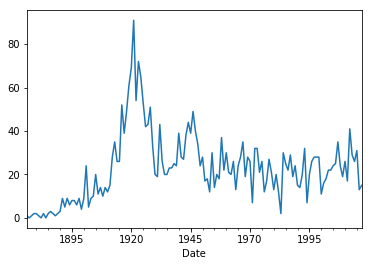

In [837]:
# Tchaikovsky over the years
(df_composers[df_composers['composerName'] == 'Tchaikovsky,  Pyotr  Ilyich']
 ['composerName'].resample('A')
 .count()
 .plot())

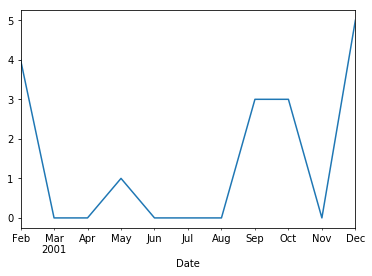

In [838]:
# Tchaikovsky at a certain year
(df_composers[(df_composers['composerName'] == 'Tchaikovsky,  Pyotr  Ilyich')
             & (df_composers.index.year == 2001)]
 ['composerName'].resample('M')
 .count()
 .plot())

In [839]:
# The 10 most popular composers
popular_composers_list = df_composers['composerName'].value_counts().nlargest(10).index.tolist()[:10]
popular_composers = df_composers[df_composers.composerName.isin(popular_composers_list)]
popular_composers_list

['Beethoven,  Ludwig  van',
 'Tchaikovsky,  Pyotr  Ilyich',
 'Mozart,  Wolfgang  Amadeus',
 'Brahms,  Johannes',
 'Wagner,  Richard',
 'Strauss,  Richard',
 'Mendelssohn,  Felix',
 'Bach,  Johann  Sebastian',
 'Dvorak,  Antonín',
 'Ravel,  Maurice']

In [840]:
# The 10 most popular composers over time
(popular_composers
 .groupby(popular_composers.index.year)
 ['composerName'].value_counts().head())

Date  composerName              
1842  Beethoven,  Ludwig  van       1
      Mozart,  Wolfgang  Amadeus    1
1843  Beethoven,  Ludwig  van       4
      Mozart,  Wolfgang  Amadeus    2
      Mendelssohn,  Felix           1
Name: composerName, dtype: int64

In [841]:
# Plot the 10 most popular composers over time
popular_composers_plot = (popular_composers
 .groupby(popular_composers.index.year)
 ['composerName'].value_counts().reset_index(name='count'))

In [842]:
popular_composers_plot[popular_composers_plot.Date == 1879]

,Date,composerName,count
137,1879,"Beethoven, Ludwig van",16
138,1879,"Wagner, Richard",8
139,1879,"Mozart, Wolfgang Amadeus",7
140,1879,"Bach, Johann Sebastian",6
141,1879,"Mendelssohn, Felix",3
142,1879,"Tchaikovsky, Pyotr Ilyich",2


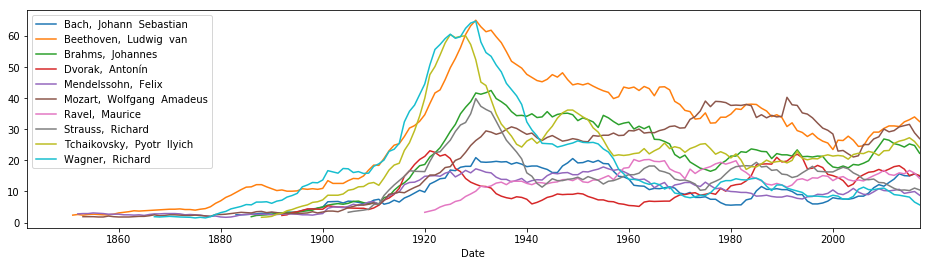

In [843]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,4))

for label, df in popular_composers_plot.groupby('composerName'):
    df.rolling(10, on='Date').mean().plot(x='Date', y='count', ax=ax, label=label)
    
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  if sys.path[0] == '':


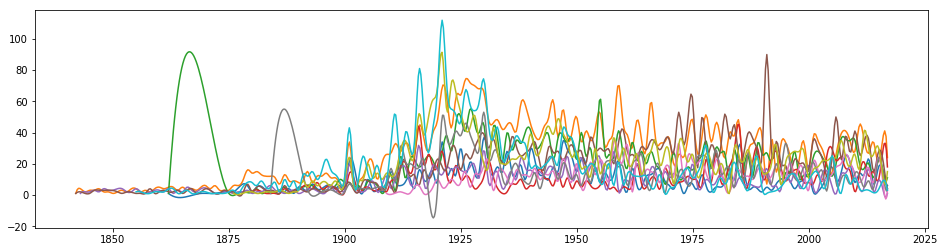

In [1005]:
fig, ax = plt.subplots(figsize=(16,4))

for label, df in popular_composers_plot.groupby('composerName'):
    
    xnew = np.linspace(
        df['Date'].unique().min(),
        df['Date'].unique().max(),600)
    
    power_smooth = spline(
        list(df['Date'].unique()),
        list(df.groupby('Date').mean()['count']),
        xnew)

    plt.plot(xnew, power_smooth)

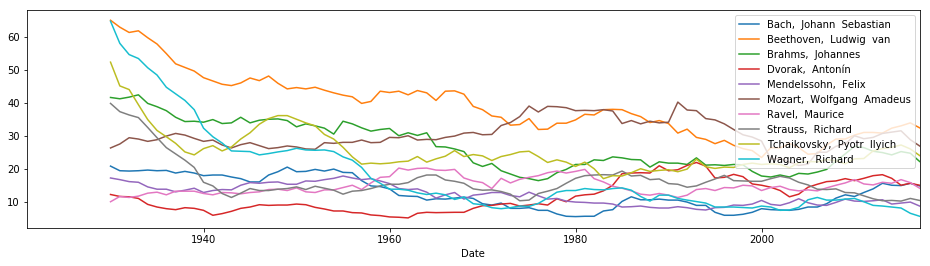

In [862]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,4))

for label, df in popular_composers_plot[popular_composers_plot['Date']>1920].groupby('composerName'):
    df.rolling(10, on='Date').mean().plot(x='Date', y='count', ax=ax, label=label)
    
plt.show()

In [844]:
popular_composers_plot.head()

,Date,composerName,count
0,1842,"Beethoven, Ludwig van",1
1,1842,"Mozart, Wolfgang Amadeus",1
2,1843,"Beethoven, Ludwig van",4
3,1843,"Mozart, Wolfgang Amadeus",2
4,1843,"Mendelssohn, Felix",1


## Fill the missing dates with a count of 0

In [845]:
popular_composers_plot['composerName'].value_counts()

Beethoven,  Ludwig  van        176
Mendelssohn,  Felix            171
Mozart,  Wolfgang  Amadeus     169
Wagner,  Richard               155
Bach,  Johann  Sebastian       140
Tchaikovsky,  Pyotr  Ilyich    139
Brahms,  Johannes              138
Dvorak,  Antonín               132
Strauss,  Richard              121
Ravel,  Maurice                107
Name: composerName, dtype: int64

In [846]:
data_output = []
composers = [
    'Beethoven',
    'Mendelssohn',
    'Mozart',
    'Wagner',
    'Bach',
    'Tchaikovsky',
    'Brahms',
    'Dvorak',
    'Strauss',
    'Ravel'
]

def getCompValueByYear(composer, year):
    row = (popular_composers_plot[
        (popular_composers_plot['composerName'].str.contains(composer))
        & (popular_composers_plot['Date'] == year)])['count']
    
    return row.item() if len(row) > 0 else 0

for c in composers:
    for y in range(1842, 2017):
        data_output.append({
            'key': c,
            'value': getCompValueByYear(c, y),
            'date': y
        })

In [847]:
data_output = pd.DataFrame(data_output)
data_output['key'].value_counts()

Mozart         175
Wagner         175
Bach           175
Ravel          175
Beethoven      175
Strauss        175
Tchaikovsky    175
Mendelssohn    175
Brahms         175
Dvorak         175
Name: key, dtype: int64

In [848]:
data_output.head()

,date,key,value
0,1842,Beethoven,1
1,1843,Beethoven,4
2,1844,Beethoven,2
3,1845,Beethoven,3
4,1846,Beethoven,3


## Export the data

In [849]:
streamgraph_data = data_output.sort_values(by=['key', 'date'])
streamgraph_data[['key', 'value', 'date']].to_csv('data.csv', index=False)

In [850]:
# data_smoothed = streamgraph_data.rolling(20, on='date').mean()
# data_smoothed.fillna(0, inplace=True)
# data_smoothed[['key', 'value', 'date']].to_csv('data.csv', index=False)

In [851]:
composers = [
    'Beethoven,  Ludwig  van',
    'Tchaikovsky,  Pyotr  Ilyich',
    'Mozart,  Wolfgang  Amadeus',
    'Brahms,  Johannes',
    'Wagner,  Richard',
    'Strauss,  Richard',
    'Mendelssohn,  Felix',
    'Bach,  Johann  Sebastian',
    'Dvorak,  Antonín',
    'Ravel,  Maurice'
]

df_composers[df_composers['composerName'].isin(composers)]['composerName'].value_counts().sum()

24799

In [852]:
df_composers[~(df_composers['composerName'].isin(composers))]['composerName'].value_counts().sum()

49611